In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import qiskit
from qiskit.tools.visualization import circuit_drawer, plot_histogram, plot_state
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QuantumProgram
from qiskit import available_backends, execute

In [2]:
%load_ext autoreload
%autoreload 2
import utils

In [373]:
def quantum_database(n, n_iter, mapping, query, measure=True):
    qc = QuantumCircuit()

    # Quantum registers.
    phone = QuantumRegister(n, name="phone")
    phoneaux = QuantumRegister(1, name="phoneaux")
    aux = QuantumRegister(n - 2, name="aux")
    name = QuantumRegister(n, name="name")
    y0 = QuantumRegister(n, name="y0")
    qc.add(phone)
    qc.add(phoneaux)
    qc.add(y0)
    qc.add(name)
    qc.add(aux)

    # Classical registers.
    phoneans = ClassicalRegister(n, name="phoneans")
    qc.add(phoneans)

    ones_y0 = [i for i, x in enumerate(query) if x == '1']
    for i in ones_y0:
        qc.x(y0[i])

    qc.h(phone)
    qc.h(phoneaux)

    for _ in range(n_iter):
        for tmp_element in mapping:
            tmp_name = tmp_element[0]
            tmp_phone = tmp_element[1]

            ones_phone = [i for i, x in enumerate(tmp_phone) if x == '1']
            zeros_phone = [i for i, x in enumerate(tmp_phone) if x == '0']

            ones_name = [i for i, x in enumerate(tmp_name) if x == '1']

            # Recording.
            controls = [phone[i] for i in ones_phone]
            anticontrols = [phone[i] for i in zeros_phone]
            targets = [name[i] for i in ones_name]

            utils.n_cx(qc, controls, anticontrols, targets, aux)

        qc.cx(name, y0)

        controls = []
        anticontrols = [y0[i] for i in range(len(y0))]
        targets = [phoneaux[0]]
        utils.n_cz(qc, controls, anticontrols, targets, aux)

        if measure:
            qc.h(phone)
            qc.h(phoneaux)
            qc.x(phone)
            qc.x(phoneaux)

            controls = [phone[i] for i in range(len(phone))]
            anticontrols = []
            targets = [phoneaux[0]]
            utils.n_cz(qc, controls, anticontrols, targets, aux)

            qc.x(phone)
            qc.x(phoneaux)
            qc.h(phone)
            qc.h(phoneaux)

    if measure:
        qc.measure(phone, phoneans)
    
    return qc

In [392]:
n = 3
n_iter = 2
mapping = [("101", "010"),
           ("111", "111"),
           ("100", "100")]
# mapping = [("1101", "0010"),
#            ("0111", "0111"),
#            ("1100", "1100")]
query = "101"
# measure = False
measure = True

qc = quantum_database(n, n_iter, mapping, query, measure)

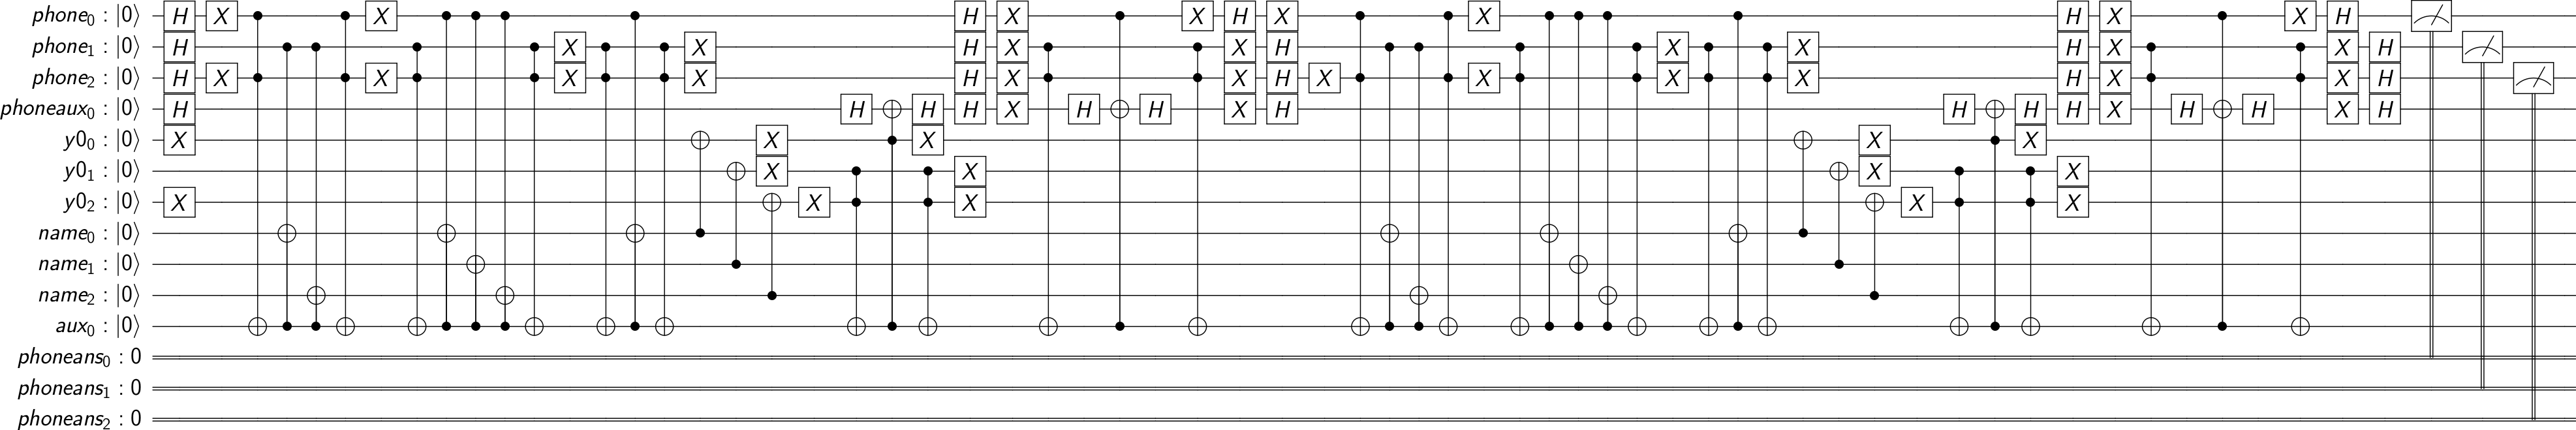

In [393]:
circuit_drawer(qc)

In [3]:
from qiskit import get_backend

In [8]:
from qiskit import register
import Qconfig

register(Qconfig.APItoken, Qconfig.config["url"])

In [9]:
available_backends()

['local_statevector_simulator',
 'local_clifford_simulator',
 'ibmqx2',
 'ibmq_qasm_simulator',
 'ibmqx5',
 'ibmqx4',
 'local_qasm_simulator',
 'local_unitary_simulator']

In [10]:
try:
    my_backend = get_backend('ibmqx4')
    print('ok')
    print(my_backend)
except Exception as e:
    print(e)

ok
ibmqx4


In [11]:
try:
    my_backend = get_backend('ibmq_qasm_simulator')
    print('ok')
    print(my_backend)
except Exception as e:
    print(e)

backend "ibmq_qasm_simulator" not found.


In [405]:
shots = 1000
result = execute(qc, backend='ibmq_qasm_simulator', shots=shots).result()

plot_histogram(result.get_counts())

LookupError: backend "ibmq_qasm_simulator" not found.

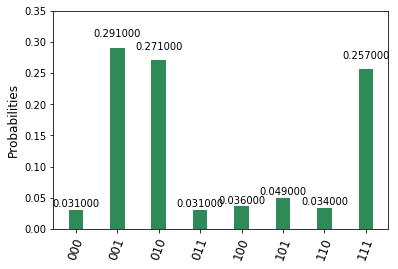

In [391]:
if measure:
    shots = 1000
    result = execute(qc, backend='local_qasm_simulator', shots=shots).result()

    plot_histogram(result.get_counts())
else:
    statevector = execute(qc, backend='local_statevector_simulator_py',
                      shots=1).result().get_data()['statevector']

    utils.plot_statevector(statevector[:2 ** 3])